In [1]:
from ModelTransfuser.ModelTransfuser import *
from ModelTransfuser.simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch

from scipy.stats import norm

import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

train_y_err = torch.ones_like(train_y)*float(pc_ab)/100.
train_y = norm.rvs(loc=train_y,scale=train_y_err)
train_y = torch.tensor(train_y).float()

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [3]:
# Define the ModelTransfuser

# Time steps for the diffusion process
#T = 20
#t = torch.linspace(0, 1, T)

model = ModelTransfuser( train_data.shape, sigma=1.01)

#model = model.load('ModelTransfuser/models/ModelTransfuser_test.pickle')

In [4]:
#with open('ModelTransfuser/models/ModelTransfuser_test.pickle', 'rb') as f:
#    model = pickle.load(f)

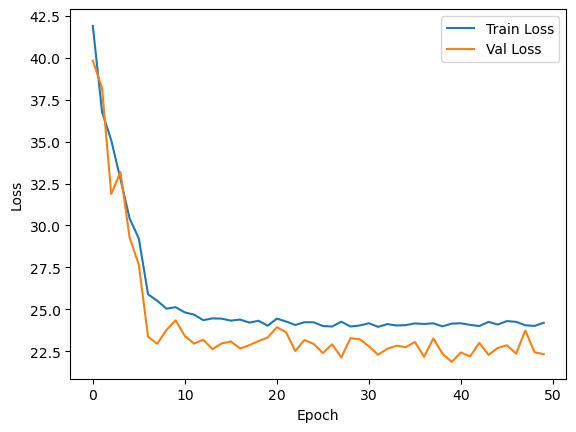

In [5]:
epoch = np.arange(0, len(model.train_loss))

plt.plot(epoch, np.array(model.train_loss)/100_000, label='Train Loss')
plt.plot(epoch, np.array(model.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [4]:
simformer = Simformer(T, train_data.shape)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
simformer.train(train_data[:10000], condition_mask_data=torch.ones_like(train_data[:10000]), val_data=val_data, condition_mask_val=torch.ones_like(val_data))

Epoch  1/10 -- Training Loss: 3200890.607 -- Validation Loss: 7152955.000


Epoch  2/10 -- Training Loss: 1133612.785 -- Validation Loss: 4756411.000


Epoch  3/10 -- Training Loss:  905812.111 -- Validation Loss: 4594413.000


Epoch  4/10 -- Training Loss:  852702.981 -- Validation Loss: 5133316.000


Epoch  5/10 -- Training Loss:  771395.578 -- Validation Loss: 3913907.750


Epoch  6/10 -- Training Loss:  731383.393 -- Validation Loss: 3744065.000


Epoch  7/10 -- Training Loss:  692735.206 -- Validation Loss: 3486144.500


Epoch  8/10 -- Training Loss:  709670.504 -- Validation Loss: 3274675.500


Epoch  9/10 -- Training Loss:  704176.135 -- Validation Loss: 3853310.000


Epoch 10/10 -- Training Loss:  684989.011 -- Validation Loss: 3790384.250


In [7]:
# Create random datapoints to denoise
sample_data_t1 = torch.randn(1000, train_data.shape[1])*2
sample_data_t0 = simformer.sample(sample_data_t1, condition_mask=torch.ones_like(sample_data_t1))

sample_data_t0.mean(axis=0)

100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


tensor([-2.1842e+00, -2.8652e+00, -2.7578e-01,  5.1279e-01,  4.4323e-01,
         7.3252e+00,  1.3575e-01,  5.8129e-02, -7.3549e-02,  1.6769e-01,
        -2.7990e-03,  3.9121e-01,  3.0421e-01,  1.5142e-01])

In [5]:
model.set_normalization(train_data)
model.train(train_data[:1000], val_data=val_data, epochs=10, device="cuda:1")

Normalization parameters set.


Epoch  1/10: 100%|██████████| 16/16 [00:00<00:00, 33.67it/s]


--- Training Loss:    8649.045 --- Validation Loss:         nan ---



Epoch  2/10: 100%|██████████| 16/16 [00:00<00:00, 50.70it/s]


--- Training Loss:    3903.253 --- Validation Loss:         nan ---



Epoch  3/10: 100%|██████████| 16/16 [00:00<00:00, 54.37it/s]


--- Training Loss:    3612.366 --- Validation Loss:  176146.167 ---



Epoch  4/10: 100%|██████████| 16/16 [00:00<00:00, 53.60it/s]


--- Training Loss:    3529.143 --- Validation Loss:  171517.444 ---



Epoch  5/10: 100%|██████████| 16/16 [00:00<00:00, 77.80it/s]


--- Training Loss:    3543.971 --- Validation Loss:  168931.571 ---



Epoch  6/10: 100%|██████████| 16/16 [00:00<00:00, 80.25it/s]


--- Training Loss:    3449.831 --- Validation Loss:  169735.610 ---



Epoch  7/10: 100%|██████████| 16/16 [00:00<00:00, 56.57it/s]


--- Training Loss:    3382.914 --- Validation Loss:  168865.373 ---



Epoch  8/10: 100%|██████████| 16/16 [00:00<00:00, 55.99it/s]


--- Training Loss:    3441.863 --- Validation Loss:  168278.639 ---



Epoch  9/10: 100%|██████████| 16/16 [00:00<00:00, 64.24it/s]


--- Training Loss:    3426.364 --- Validation Loss:  168252.846 ---



Epoch 10/10: 100%|██████████| 16/16 [00:00<00:00, 53.52it/s]


--- Training Loss:    3286.891 --- Validation Loss:  167471.500 ---

Training finished after 0.2 minutes


## Data Generation

In [7]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [8]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [9]:
#sample_data_t1 = torch.randn(val_data.shape)*(1-mask)+(mask*val_data)

In [10]:
data = val_data[:1000, mask.type(torch.bool)]

In [16]:
p3=model.sample(data, condition_mask=mask, device="cuda:2", timesteps=20).to("cpu")

100%|██████████| 1000/1000 [02:33<00:00,  6.54it/s]


In [53]:
#p = model.sample(val_data[:1000], condition_mask=mask.repeat(1000,1), device="cuda:1").to("cpu")

In [13]:
p3.shape

torch.Size([1000, 1000, 14])

In [18]:
p = model.x_t[:,-3,:,:]

In [19]:
torch.mean(100*torch.abs((val_data[:1000]-p3.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([ 10.9240,   8.4523, 408.3209,  15.0610,  17.2893,  76.8954])

In [18]:
torch.mean(100*torch.abs((val_data[:1000]-p.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([ 10.9053,   8.3656, 397.7334,  15.0687,  17.3367,  77.0977])

In [11]:
p=model.sample(data[1], condition_mask=mask, device="cuda:0").to("cpu")

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


In [20]:
p.mean(axis=1)

tensor([[-2.3398, -2.9097, -0.3288,  0.5387,  0.4863,  7.2199,  0.2157,  0.2965,
         -0.1564,  0.3183,  0.0354,  0.5842,  0.4625,  0.3285]])

In [13]:
val_data[1]

tensor([-2.0697, -2.7872, -0.3723,  0.4962,  0.4666,  7.0081,  0.2157,  0.2965,
        -0.1564,  0.3183,  0.0354,  0.5842,  0.4625,  0.3285])

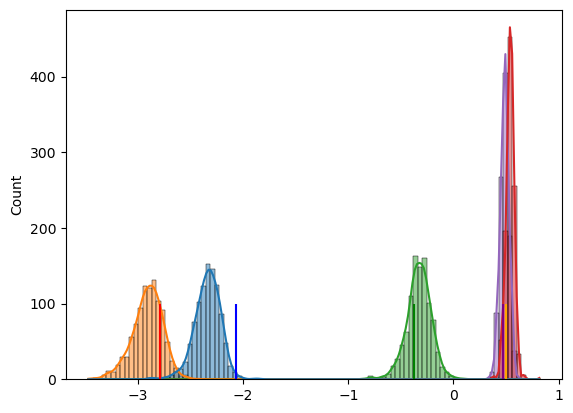

In [21]:
sns.histplot(p[0,:,:5], bins=100, kde=True,color=['blue','red','green','orange','purple'], legend=False)
plt.vlines(val_data[1,:5], 0, 100, color=['blue','red','green','orange','purple'])
#plt.vlines(val_data[1,0], 0, 10, color='red')
plt.show()

In [14]:
p2 = model.sample(val_data[:1000], condition_mask=(-1)*(mask.repeat(1000,1)-1), device="cuda:1").to("cpu")

RuntimeError: shape mismatch: value tensor of shape [14000] cannot be broadcast to indexing result of shape [6000]

In [ ]:
torch.mean(100*torch.abs((val_data[:1000]-p2.mean(axis=1))/val_data[:1000]), axis=0)[6:]

In [ ]:
#sns.histplot(p2[1,:,6:], bins=1000, kde=True )
sns.kdeplot(p2[1,:,6:], bw_adjust=0.1)
plt.show()

In [11]:
denoising_data.shape

(1000, 21, 14)

In [20]:
#scaling_factor = -0.5*model.sigma**(2*t)*(1/T)
denoising_data = model.x_t.detach().numpy()
#denoising_data = denoising_data * (model.std.detach().numpy() + 1e-6) + model.mean.detach().numpy()
score_t = model.score_t.detach().numpy()
dx = model.dx_t.detach().numpy()
t = model.t.detach().numpy()

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,2)
    plt.ylim(-5,2)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')
    
    sns.set_style("white")
    sns.kdeplot(x=denoising_data[0,i,:,0], y=denoising_data[0,i,:,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    #sns.kdeplot(x=denoising_data[:,i,0], y=denoising_data[:,i,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps+1) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_new.gif', writer=writer)

KeyboardInterrupt: 

In [ ]:
data.shape

In [ ]:
model.forward_diffusion_sample(val_data[:1], t[50])

In [ ]:
model.timesteps

In [16]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = model.forward_diffusion_sample(train_data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")

"""
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)
"""
matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

In [ ]:
plt.scatter(denoising_data[0,0,:,0], denoising_data[0,0,:,1], s=1)
plt.scatter(denoising_data[0,-1,:,0], denoising_data[0,-1,:,1], s=1)
plt.show()

In [ ]:
denoising_data[0,:,0,:] * (model.std.detach().numpy() + 1e-6) + model.mean.detach().numpy()

In [ ]:
p3[0,0,0]